<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/Autoencoder_Zero_Day_ICMPFlood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install imbalanced-learn


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [ ]:
# Usando shape
num_amostras = encoded.shape[0]
print(f"Número de amostras: {num_amostras}")

# Usando len()
num_amostras_len = len(encoded)
print(f"Número de amostras (usando len): {num_amostras_len}")

Número de amostras: 1215890
Número de amostras (usando len): 1215890


In [ ]:
# Exibir os nomes de todas as colunas
colunas = encoded.columns.tolist()  # Converte o Index em uma lista
print("Nomes das colunas:")
for coluna in colunas:
    print(coluna)

Nomes das colunas:
Unnamed: 0
Seq
Dur
RunTime
Mean
Sum
Min
Max
sTos
dTos
sTtl
dTtl
sHops
dHops
TotPkts
SrcPkts
DstPkts
TotBytes
SrcBytes
DstBytes
Offset
sMeanPktSz
dMeanPktSz
Load
SrcLoad
DstLoad
Loss
SrcLoss
DstLoss
pLoss
SrcGap
DstGap
Rate
SrcRate
DstRate
SrcWin
DstWin
sVid
dVid
SrcTCPBase
DstTCPBase
TcpRtt
SynAck
AckDat
Label
Attack Type
Attack Tool
 *        
 *    V   
 *    f   
 e        
 e    f   
 e &      
 e *      
 e d      
 e g      
 e i      
 e r      
 e s      
 eU       
e        
arp
icmp
ipv6-icmp
llc
lldp
sctp
tcp
udp
ACC
CON
ECO
FIN
INT
NRS
REQ
RSP
RST
TST
URP
Shutdown
Start
Status
39
4
52
54
af11
af12
af41
cs0
cs4
cs6
cs7
ef
nan


In [ ]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [ ]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

Features
* Seq: Sequência de pacotes.
* Offset: Deslocamento em bytes.
* sTtl: Time to Live da fonte.
* tcp: Indica se o protocolo TCP está sendo usado.
* AckDat: Dados de reconhecimento.
* RST: Sinalizador de reinício TCP.
* INT: Interrupções no fluxo de dados.
* TcpRtt: Tempo de ida e volta do TCP.
* icmp: Indica se o protocolo ICMP está presente.
* sMeanPktSz: Tamanho médio do pacote da fonte.
* FIN: Sinalizador de finalização de conexão.
* sHops: Número de saltos até o destino.
* Mean: Valor médio de um conjunto de dados.
* dTtl: Time to Live do destino.
* SrcBytes: Bytes enviados da fonte.
* TotBytes: Total de bytes.
* dMeanPktSz: Tamanho médio do pacote do destino.
* Status: Estado da conexão.
* cs0: Parâmetro de controle.
* SrcWin: Janela de origem TCP.
* sTos: Tipo de serviço.
* CON: Conexões.
* REQ: Requisições.
* Loss: Taxa de perda de pacotes.

In [ ]:

import pandas as pd

# Selecionar apenas as colunas 'Label' e 'Attack Type'
icmp_flood_samples = encoded[['Label', 'icmp', 'Attack Type']]

icmp_flood_samples

,Label,icmp,Attack Type
0,Benign,1.0,Benign
1,Benign,1.0,Benign
2,Benign,0.0,Benign
3,Benign,0.0,Benign
4,Benign,0.0,Benign
...,...,...,...
1215885,Benign,0.0,Benign
1215886,Benign,0.0,Benign
1215887,Benign,0.0,Benign
1215888,Benign,0.0,Benign


In [ ]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Função para monitoramento de recursos
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

class ResourceMonitorSklearn:
    def __init__(self):
        self.cpu_usage = []
        self.memory_usage = []

    def _reset_usage(self):
        self.cpu_usage = []
        self.memory_usage = []

    def _plot_usage(self, phase="Train", labels=None, save_path="resource_usage.png"):
        labels = labels or list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 2, 1)
        plt.plot(labels, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Etapa")
        plt.ylabel("Uso de CPU (%)")
        plt.title(f"Consumo de CPU ({phase})")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 2, 2)
        plt.plot(labels, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Etapa")
        plt.ylabel("Memória (MB)")
        plt.title(f"Consumo de Memória ({phase})")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()
        plt.clf()
        plt.close()

    def monitor_training(self, model, X_train):
        self._reset_usage()
        print("\n[Início do Treinamento]")

        start_time = time.time()

        # Antes do treino
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"[Pré-Treino] CPU: {cpu:.2f}%, Memória: {mem:.2f} MB")

        # Treinamento
        model.fit(X_train, X_train, epochs=10, batch_size=32)

        # Após treino
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"[Pós-Treino] CPU: {cpu:.2f}%, Memória: {mem:.2f} MB")

        gc.collect()

        total_time = time.time() - start_time
        print("\n[Fim do Treinamento]")
        print(f"Tempo total: {total_time:.2f} segundos")
        print(f"Uso médio de CPU: {np.mean(self.cpu_usage):.2f}%")
        print(f"Consumo médio de memória: {np.mean(self.memory_usage):.2f} MB")

        self._plot_usage(phase="Train", labels=["Pré", "Pós"], save_path="resource_usage_train_autoencoder.png")

    def monitor_test(self, model, X_test):
        self._reset_usage()
        print("\n[Início da Predição/Teste]")
        start_time = time.time()

        step_size = max(1, len(X_test) // 10)
        labels = []

        for i in range(0, len(X_test), step_size):
            end_i = min(i + step_size, len(X_test))
            cpu, mem = monitor_resource_usage()
            self.cpu_usage.append(cpu)
            self.memory_usage.append(mem)
            labels.append(f"Bloco {len(labels)+1}")
            _ = model.predict(X_test[i:end_i])

        total_time = time.time() - start_time
        print("\n[Fim da Predição/Teste]")
        print(f"Tempo total: {total_time:.2f} segundos")
        print(f"Uso médio de CPU (Teste): {np.mean(self.cpu_usage):.2f}%")
        print(f"Consumo médio de memória (Teste): {np.mean(self.memory_usage):.2f} MB")

        self._plot_usage(phase="Test", labels=labels, save_path="resource_usage_test_autoencoder.png")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from keras.regularizers import l2

# Configuração das features e rótulos
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss', 'Attack Type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Divida os dados normalmente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifique as amostras ICMPFlood no conjunto de treino
train_zero_day_indices = X_train[X_train['Attack Type'] == 'ICMPFlood'].index

# Remova essas amostras de ICMPFlood do conjunto de treino
X_train_clean = X_train.drop(train_zero_day_indices)
y_train_clean = y_train.drop(train_zero_day_indices)

# Identifique as amostras ICMPFlood no conjunto de teste
test_zero_day_indices = X_test[X_test['Attack Type'] == 'ICMPFlood'].index

# Mantenha as amostras de ICMPFlood no conjunto de teste
X_test_zero_day = X_test.loc[test_zero_day_indices]
y_test_zero_day = y_test.loc[test_zero_day_indices]

# Verificar a distribuição das classes no conjunto de teste
print(f"Zero-day presente no conjunto de teste: {any(test_zero_day_indices.isin(X_test_zero_day.index))} \n")

# Verificar as distribuições
print("Distribuição do conjunto de treino binário:", pd.Series(y_train_clean).value_counts())
print("Distribuição do conjunto de teste binário:", pd.Series(y_test_zero_day).value_counts())

# Remover a coluna 'Attack Type' das features de treino e teste
X_train_clean = X_train_clean.drop(columns=['Attack Type'])
X_test = X_test.drop(columns=['Attack Type'])
X_test_zero_day = X_test_zero_day.drop(columns=['Attack Type'])

Zero-day presente no conjunto de teste: True 

Distribuição do conjunto de treino binário: Label
Malicious    589852
Benign       381943
Name: count, dtype: int64
Distribuição do conjunto de teste binário: Label
Malicious    238
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd

# Configurar o SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE no conjunto de treinamento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

# Verificar distribuição das classes após o SMOTE
print(f"Distribuição após SMOTE:\n{pd.Series(y_train_balanced).value_counts()}")

# Normalizar os dados após o SMOTE
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)

# Normalizar o conjunto de teste com o mesmo scaler ajustado no treino
X_test_combined = scaler.transform(X_test)
y_test_combined = y_test

Distribuição após SMOTE:
Label
Malicious    589852
Benign       589852
Name: count, dtype: int64


In [ ]:
# Verificar a dimensão do teste
print(X_test_combined.shape)
print(y_test_combined.shape)
print(f"Distribuição Teste:\n{pd.Series(y_test_combined).value_counts()}")

(243178, 24)
(243178,)
Distribuição Teste:
Label
Malicious    147384
Benign        95794
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Criar o codificador
label_encoder = LabelEncoder()

# Ajustar o codificador aos rótulos de treinamento e teste
y_train_balanced = label_encoder.fit_transform(y_train_balanced)
y_test_combined = label_encoder.transform(y_test_combined)

# Verificar os tipos após a transformação
print(y_train_balanced.dtype)
print(y_test_combined.dtype)

int64
int64


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Carregar os dados (supondo que você já tenha X e y)
# Aqui, substitua o seu código para carregar e pré-processar os dados

# Criando o codificador e decodificador para o Autoencoder
def create_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))

    # Codificador
    encoded = layers.Dense(128, activation='relu')(input_layer)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(32, activation='relu')(encoded)  # Espaço latente (codificação)

    # Decodificador
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)  # Reconstrução

    # Criando o modelo autoencoder
    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')  # Usando erro quadrático médio (MSE) como perda
    return autoencoder

# Definir e treinar o Autoencoder
input_dim = X_train_balanced.shape[1]
autoencoder = create_autoencoder(input_dim)

# Treinamento do modelo
autoencoder.fit(X_train_balanced, X_train_balanced, epochs=10, batch_size=32, validation_data=(X_test_combined, X_test_combined))

# Fazer previsões (reconstrução dos dados)
reconstructed = autoencoder.predict(X_test_combined)

# Calcular o erro de reconstrução
mse = np.mean(np.power(X_test_combined - reconstructed, 2), axis=1)

Epoch 1/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 0.6622 - val_loss: 0.6176
Epoch 2/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 0.6460 - val_loss: 0.6175
Epoch 3/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 0.6525 - val_loss: 0.6176
Epoch 4/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - loss: 0.6515 - val_loss: 0.6174
Epoch 5/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 0.6544 - val_loss: 0.6176
Epoch 6/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - loss: 0.6500 - val_loss: 0.6177
Epoch 7/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 0.6501 - val_loss: 0.6174
Epoch 8/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 0.6528 - val_loss: 0.6175
Epoch 9/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 0.6472 - val_loss: 0.6174
Epoch 10/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - loss: 0.6510 - val_loss: 0.6176
7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 886us/step


In [ ]:
# Usar o erro de reconstrução como métrica para detectar anomalias
threshold = np.percentile(mse, 95)  # Definir um limiar baseado nos 95% maiores erros
y_pred = (mse > threshold).astype(int)

# Avaliação do modelo
from sklearn.metrics import classification_report
print(classification_report(y_test_combined, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.3867    0.9327    0.5468     95794
           1     0.4697    0.0387    0.0716    147384

    accuracy                         0.3909    243178
   macro avg     0.4282    0.4857    0.3092    243178
weighted avg     0.4370    0.3909    0.2588    243178



In [ ]:
# Criar uma instância do monitor de recursos
resource_monitor = ResourceMonitorSklearn()


[Início do Treinamento]
[Pré-Treino] CPU: 0.10%, Memória: 4030.64 MB
Epoch 1/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - loss: 0.6499
Epoch 2/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - loss: 0.6498
Epoch 3/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.6488
Epoch 4/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - loss: 0.6454
Epoch 5/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - loss: 0.6517
Epoch 6/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.6521
Epoch 7/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - loss: 0.6524
Epoch 8/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.6485
Epoch 9/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - loss: 0.6611
Epoch 10/10
36866/36866 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - loss: 0.6536
[Pós-Treino] CPU: 1.20%, Memória: 4138.75 MB

[Fim do Treinamento]
Tempo total: 687.74 segundos
Uso médio de CPU: 0.65%
Consumo médio de memória: 4084.70 MB


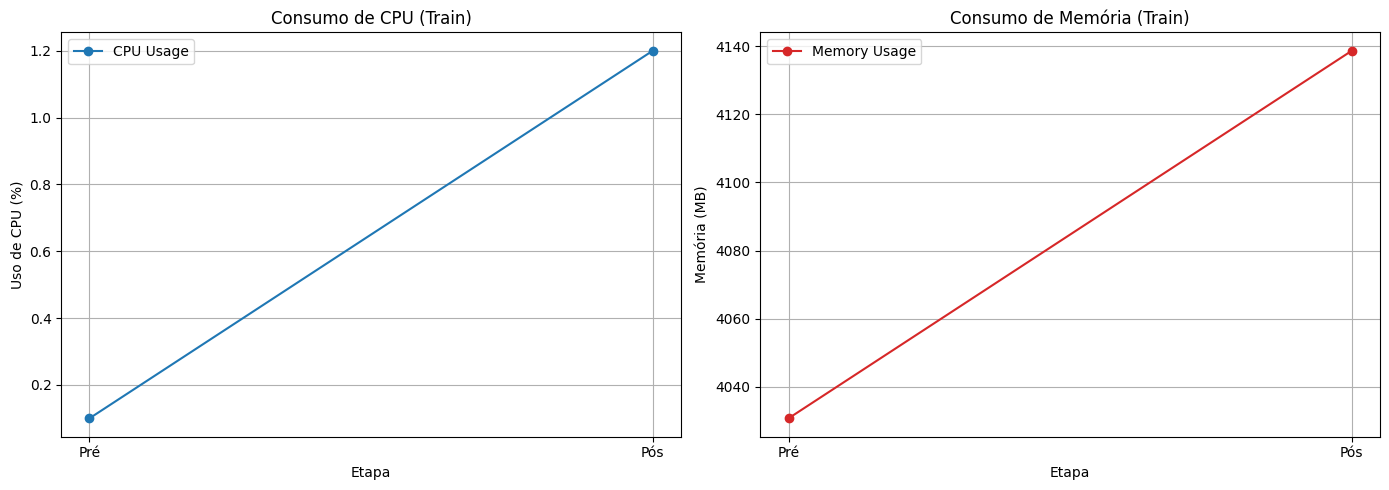

In [ ]:
# Monitorar o uso de recursos durante o treinamento do autoencoder
resource_monitor.monitor_training(autoencoder, X_train_balanced)





[Início da Predição/Teste]
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

[Fim da Predição/Teste]
Tempo total: 10.78 segundos
Uso médio de CPU (Teste): 0.28%
Consumo médio de memória (Teste): 4146.69 MB


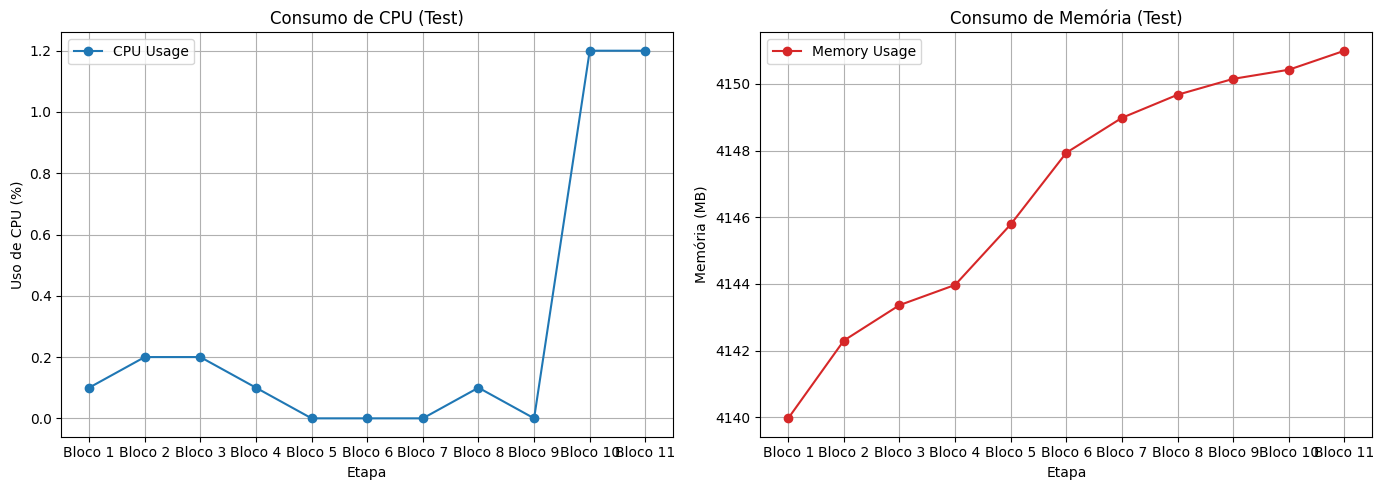

In [ ]:
# Monitorar o uso de recursos durante o teste
resource_monitor.monitor_test(autoencoder, X_test_combined)

In [ ]:
#print(f"Tamanho de X_test_zero_day: {X_test_zero_day.shape}")
#print(f"Tamanho de y_test_zero_day: {y_test_zero_day.shape}")

In [ ]:
# Prever com o modelo para as amostras zero-day
y_pred_zero_day = autoencoder.predict(X_test_zero_day)  # Removendo os nomes das colunas

accuracy_zero_day = (y_pred_zero_day == 1).mean()
print(f"Acurácia para amostras zero-day: {accuracy_zero_day:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Acurácia para amostras zero-day: 0.1292


In [ ]:
print(y_test_zero_day)

765058    Malicious
35586     Malicious
36988     Malicious
766062    Malicious
35511     Malicious
            ...    
35882     Malicious
765081    Malicious
35852     Malicious
36923     Malicious
766407    Malicious
Name: Label, Length: 238, dtype: object


In [ ]:
y_test_zero_day = [0. if label == 'Benign' else 1.0 for label in y_test_zero_day]
print(y_test_zero_day)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [ ]:
print(y_pred_zero_day)

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]


In [ ]:
import numpy as np

# Caso y_pred_zero_day seja um array numpy, você pode fazer isso:
y_pred_zero_day = np.where(y_pred_zero_day == 0, 0.0, 1.0)

# Caso queira verificar a transformação:
print(y_pred_zero_day)

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]


In [ ]:
y_pred_zero_day = np.array(y_pred_zero_day, dtype='float32')

In [ ]:
# Caso o modelo tenha múltiplas saídas (ou múltiplas classes), pegue a previsão com maior probabilidade
y_pred_zero_day = np.argmax(y_pred_zero_day, axis=1)  # Se for multiclass, pegue a classe com maior probabilidade

# Agora, você pode comparar y_pred_zero_day com y_test_zero_day
correct_classifications = (y_pred_zero_day == y_test_zero_day).sum()

# Total de amostras
total_zero_day_samples = len(y_test_zero_day)

print(f"Zero-day samples classified correctly: {correct_classifications}/{total_zero_day_samples}")

Zero-day samples classified correctly: 0/238


In [ ]:
# Gerar o relatório de classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test_zero_day, y_pred_zero_day, digits=4, zero_division=1))


--- Relatório de Classificação ---
              precision    recall  f1-score   support

         0.0     0.0000    1.0000    0.0000       0.0
         1.0     1.0000    0.0000    0.0000     238.0

    accuracy                         0.0000     238.0
   macro avg     0.5000    0.5000    0.0000     238.0
weighted avg     1.0000    0.0000    0.0000     238.0

